In [53]:
!pip install scikit-build
!pip install pyikarus  --no-build-isolation --verbose --upgrade


Using pip 23.0.1 from /dune/dune-common/build-cmake/dune-env/lib/python3.10/site-packages/pip (python 3.10)


### Import all packages

In [54]:
import matplotlib
import dune.grid
import dune.functions
import pyikarus as iks
import pyikarus.finite_elements
import pyikarus.utils
import pyikarus.assembler
import pyikarus.dirichletValues
import numpy as np
import scipy as sp
from dune.vtk import  vtkWriter


### Create grid

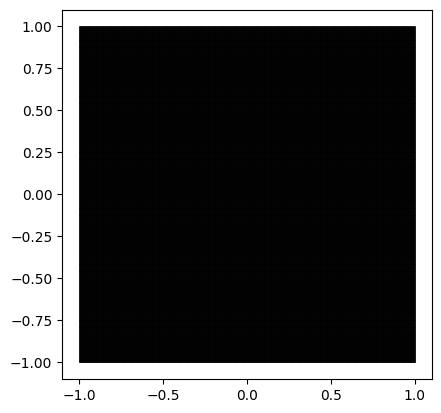

In [55]:
lowerLeft = [-1,-1]
upperRight = [1,1]
elements = [3,3]

grid = dune.grid.structuredGrid(lowerLeft,upperRight,elements)
grid.hierarchicalGrid.globalRefine(7)
grid.plot()

### Add Lagrangian basis

In [56]:
basisLagrange1 = dune.functions.defaultGlobalBasis(grid, dune.functions.Power(dune.functions.Lagrange(order=1),2))
print('We have {} dofs.'.format(len(basisLagrange1)))
print('We have {} vertices.'.format(grid.size(2)))
print('We have {} elements.'.format(grid.size(0)))

We have 296450 dofs.
We have 148225 vertices.
We have 147456 elements.


### Init load factor and displacement vector

In [57]:
d = np.zeros(len(basisLagrange1))
lambdaLoad = iks.ValueWrapper(3.0)

### Create finite element requirements

In [58]:
req= iks.FErequirements()
req.addAffordance(iks.ScalarAffordances.mechanicalPotentialEnergy)
req.addAffordance(iks.VectorAffordances.forces)
req.addAffordance(iks.MatrixAffordances.stiffness)

req.insertParameter(iks.FEParameter.loadfactor,lambdaLoad)
req.insertGlobalSolution(iks.FESolutions.displacement,d)

### Define volume load and boundary loads

In [59]:
def volumeLoad(x,lambdaVal) :
    return np.array([lambdaVal*x[0]*2*0, 2*lambdaVal*x[1]*0])

def neumannLoad(x,lambdaVal) :
    return np.array([lambdaVal*100, lambdaVal])

neumannVertices = np.zeros(grid.size(2)*2, dtype=bool)
basisLagrange1.interpolate(neumannVertices, lambda x :  True  if x[1]==1 else False)

boundaryPatch = iks.utils.boundaryPatch(grid,neumannVertices)

### Create vector of finite elements

In [60]:
fes = []
for e in grid.elements:
    fes.append(iks.finite_elements.linearElasticElement(basisLagrange1,e,1000,0.2,volumeLoad,boundaryPatch,neumannLoad))

### print forces and stiffness of first element

In [61]:
forces = np.zeros(8)
stiffness = np.zeros((8,8))
fes[0].calculateVector(req,forces)
fes[0].calculateMatrix(req,stiffness)
np.set_printoptions(precision=3)
print('Forces:\n {}'.format(forces))
print('Stiffness:\n {}'.format(stiffness))

Forces:
 [0. 0. 0. 0. 0. 0. 0. 0.]
Stiffness:
 [[ 486.111  156.25  -277.778  -52.083   34.722   52.083 -243.056 -156.25 ]
 [ 156.25   486.111   52.083   34.722  -52.083 -277.778 -156.25  -243.056]
 [-277.778   52.083  486.111 -156.25  -243.056  156.25    34.722  -52.083]
 [ -52.083   34.722 -156.25   486.111  156.25  -243.056   52.083 -277.778]
 [  34.722  -52.083 -243.056  156.25   486.111 -156.25  -277.778   52.083]
 [  52.083 -277.778  156.25  -243.056 -156.25   486.111  -52.083   34.722]
 [-243.056 -156.25    34.722   52.083 -277.778  -52.083  486.111  156.25 ]
 [-156.25  -243.056  -52.083 -277.778   52.083   34.722  156.25   486.111]]


### Create Dirichlet boundary conditions

In [62]:
dirichletValues = iks.dirichletValues.dirichletValues(basisLagrange1) 

def fixBottomEdge(vec,localIndex,localView,intersection):
    if (intersection.geometry.center[1]==-1):
        vec[localView.index(localIndex)]= True

dirichletValues.fixBoundaryDOFsUsingLocalViewAndIntersection(fixBottomEdge)

### Create assembler

In [63]:
assembler = iks.assembler.sparseFlatAssembler(fes,dirichletValues)
#assemblerDense = iks.assembler.denseFlatAssembler(fes,dirichletValues)

Msparse = assembler.getMatrix(req)
forces = assembler.getVector(req)
#print(Msparse)
#print(forces)

### Solve for displacements and write to paraview

In [64]:
d = sp.sparse.linalg.spsolve(Msparse,-forces)
dispFunc = basisLagrange1.asFunction(d)

writer = vtkWriter( grid, "nameTest",  pointData   = {( "displacement",(0,1)):dispFunc})

### Plot here using matplot lib

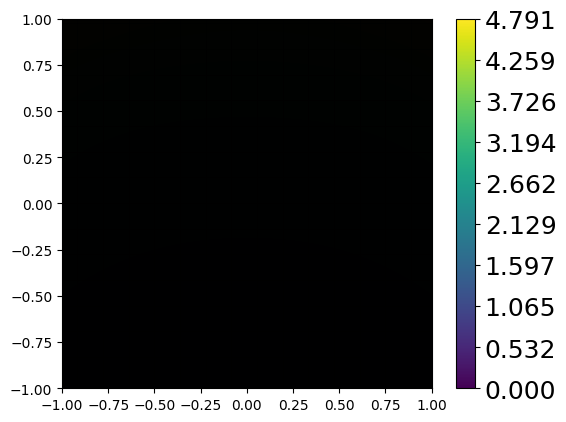

In [65]:
import dune.plotting
dune.plotting.plot(solution=dispFunc)